# **Data_understanding**

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# For saving models
import joblib
import os

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

In [2]:
shopper_spectrum = pd.read_csv('/home/dataghost/DataScienceAndBeyond/Project_3-Shopper_Spectrum_Segementation_and_recommendation/Notebook/online_retail.csv')
shopper_spectrum.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
shopper_spectrum.shape

(541909, 8)

In [4]:
shopper_spectrum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
shopper_spectrum.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [6]:
shopper_spectrum.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
shopper_spectrum.duplicated().sum()

np.int64(5268)

# **Data_preprocessing**

In [8]:
# Unique values for categorical columns
categorical_cols = shopper_spectrum.select_dtypes(include=['object']).columns
print(f"\nCategorical Columns Unique Values:")
for col in categorical_cols:
    print(f"{col}: {shopper_spectrum[col].unique()}")


Categorical Columns Unique Values:
InvoiceNo: ['536365' '536366' '536367' ... '581585' '581586' '581587']
StockCode: ['85123A' '71053' '84406B' ... '90214U' '47591b' '23843']
Description: ['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' ... 'lost'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']
InvoiceDate: ['2022-12-01 08:26:00' '2022-12-01 08:28:00' '2022-12-01 08:34:00' ...
 '2023-12-09 12:31:00' '2023-12-09 12:49:00' '2023-12-09 12:50:00']
Country: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']


In [10]:
"""Data preprocessing according to project requirements"""
print("=== DATA PREPROCESSING ===")
initial_shape = shopper_spectrum.shape
print(f"Initial dataset shape: {initial_shape}")

=== DATA PREPROCESSING ===
Initial dataset shape: (541909, 8)


In [11]:
# Remove rows with missing CustomerID
shopper_spectrum = shopper_spectrum.dropna(subset=['CustomerID'])
print(f"After removing missing CustomerID: {shopper_spectrum.shape}")

After removing missing CustomerID: (406829, 8)


In [12]:
# Exclude cancelled invoices (InvoiceNo starting with 'C')
shopper_spectrum = shopper_spectrum[~shopper_spectrum['InvoiceNo'].astype(str).str.startswith('C')]
print(f"After removing cancelled invoices: {shopper_spectrum.shape}")

After removing cancelled invoices: (397924, 8)


In [14]:
# Remove negative or zero quantities and prices
shopper_spectrum = shopper_spectrum[(shopper_spectrum['Quantity'] > 0) & (shopper_spectrum['UnitPrice'] > 0)]
print(f"After removing negative/zero quantities and prices: {shopper_spectrum.shape}")

After removing negative/zero quantities and prices: (397884, 8)


In [15]:
# Convert InvoiceDate to datetime
shopper_spectrum['InvoiceDate'] = pd.to_datetime(shopper_spectrum['InvoiceDate'])

In [16]:
shopper_spectrum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [17]:
# Create TotalAmount column
shopper_spectrum['TotalAmount'] = shopper_spectrum['Quantity'] * shopper_spectrum['UnitPrice']

In [18]:
shopper_spectrum.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [19]:
# Convert CustomerID to int
shopper_spectrum['CustomerID'] = shopper_spectrum['CustomerID'].astype(int)

In [21]:
shopper_spectrum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
 8   TotalAmount  397884 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.4+ MB


In [22]:
print(f"Data preprocessing completed!")
print(f"Final dataset shape: {shopper_spectrum.shape}")

Data preprocessing completed!
Final dataset shape: (397884, 9)


# **=== EXPLORATORY DATA ANALYSIS ===**

In [23]:
"""Exploratory Data Analysis"""
print("=== EXPLORATORY DATA ANALYSIS ===")

=== EXPLORATORY DATA ANALYSIS ===


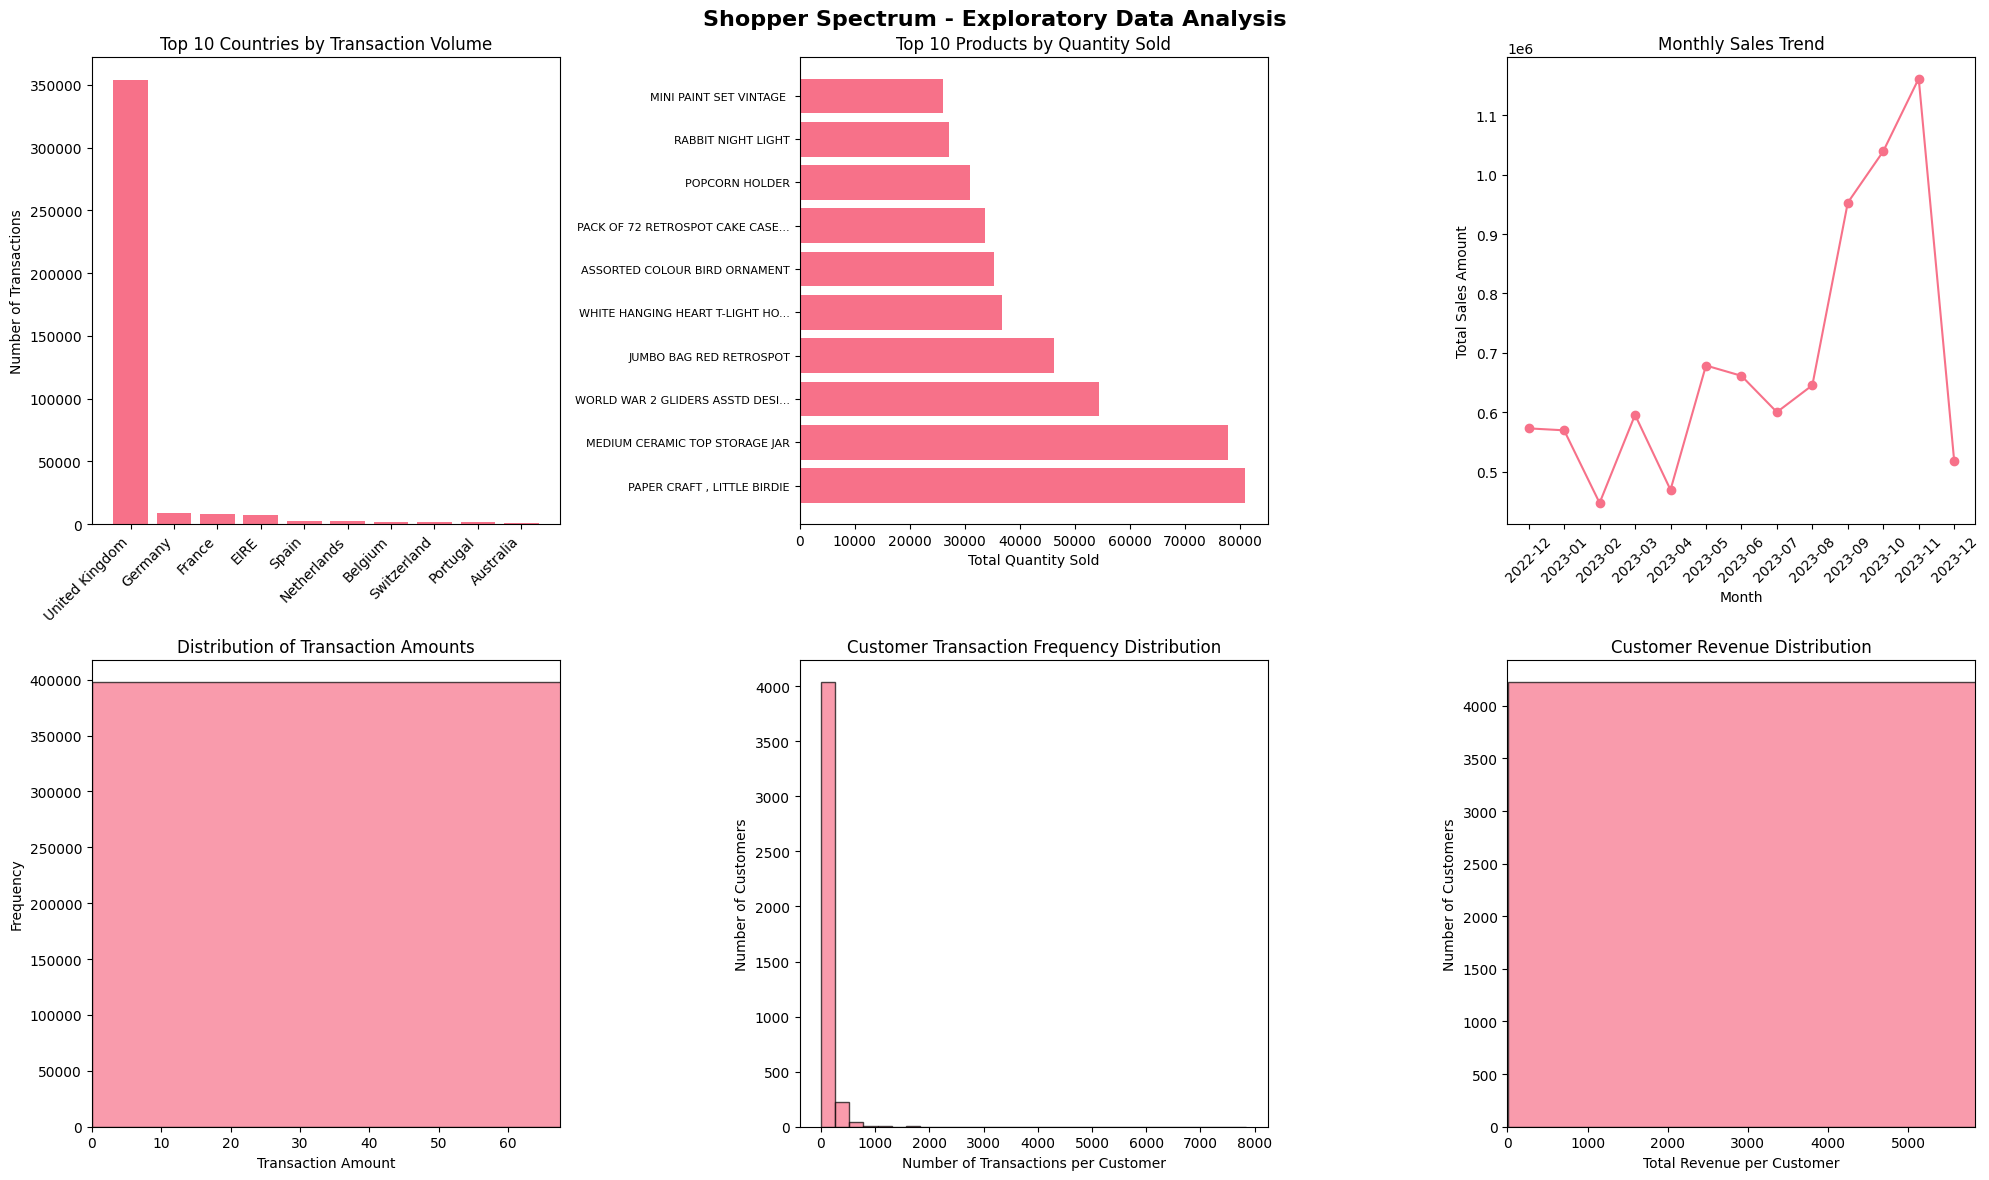

In [28]:
# Set up the plotting
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Shopper Spectrum - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Transaction volume by country
country_counts = shopper_spectrum['Country'].value_counts().head(10)
axes[0, 0].bar(range(len(country_counts)), country_counts.values)
axes[0, 0].set_title('Top 10 Countries by Transaction Volume')
axes[0, 0].set_xticks(range(len(country_counts)))
axes[0, 0].set_xticklabels(country_counts.index, rotation=45, ha='right')
axes[0, 0].set_ylabel('Number of Transactions')

# 2. Top-selling products
top_products = shopper_spectrum.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
axes[0, 1].barh(range(len(top_products)), top_products.values)
axes[0, 1].set_title('Top 10 Products by Quantity Sold')
axes[0, 1].set_yticks(range(len(top_products)))
axes[0, 1].set_yticklabels([desc[:30] + '...' if len(desc) > 30 else desc 
                           for desc in top_products.index], fontsize=8)
axes[0, 1].set_xlabel('Total Quantity Sold')

# 3. Purchase trends over time
monthly_sales = shopper_spectrum.groupby(shopper_spectrum['InvoiceDate'].dt.to_period('M'))['TotalAmount'].sum()
axes[0, 2].plot(monthly_sales.index.astype(str), monthly_sales.values, marker='o')
axes[0, 2].set_title('Monthly Sales Trend')
axes[0, 2].set_xlabel('Month')
axes[0, 2].set_ylabel('Total Sales Amount')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Monetary distribution per transaction
axes[1, 0].hist(shopper_spectrum['TotalAmount'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Transaction Amounts')
axes[1, 0].set_xlabel('Transaction Amount')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlim(0, shopper_spectrum['TotalAmount'].quantile(0.95))

# 5. Customer transaction frequency
customer_freq = shopper_spectrum.groupby('CustomerID').size()
axes[1, 1].hist(customer_freq, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Customer Transaction Frequency Distribution')
axes[1, 1].set_xlabel('Number of Transactions per Customer')
axes[1, 1].set_ylabel('Number of Customers')

# 6. Revenue by customer
customer_revenue = shopper_spectrum.groupby('CustomerID')['TotalAmount'].sum()
axes[1, 2].hist(customer_revenue, bins=30, edgecolor='black', alpha=0.7)
axes[1, 2].set_title('Customer Revenue Distribution')
axes[1, 2].set_xlabel('Total Revenue per Customer')
axes[1, 2].set_ylabel('Number of Customers')
axes[1, 2].set_xlim(0, customer_revenue.quantile(0.95))

plt.tight_layout()
plt.show()

In [29]:
# Print summary statistics
print("\n=== SUMMARY STATISTICS ===")
print(f"Total number of customers: {shopper_spectrum['CustomerID'].nunique()}")
print(f"Total number of products: {shopper_spectrum['StockCode'].nunique()}")
print(f"Total number of transactions: {shopper_spectrum['InvoiceNo'].nunique()}")
print(f"Date range: {shopper_spectrum['InvoiceDate'].min()} to {shopper_spectrum['InvoiceDate'].max()}")
print(f"Total revenue: ${shopper_spectrum['TotalAmount'].sum():,.2f}")


=== SUMMARY STATISTICS ===
Total number of customers: 4338
Total number of products: 3665
Total number of transactions: 18532
Date range: 2022-12-01 08:26:00 to 2023-12-09 12:50:00
Total revenue: $8,911,407.90
